<a href="https://colab.research.google.com/github/kiril-buga/Neural-Network-Training-Project/blob/main/ECG_Model_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ECG Baseline Model Training

This notebook trains a baseline deep learning model on preprocessed ECG data:
1. Loads preprocessed windows and labels from ECG_Preprocessing.ipynb
2. Performs patient-level train/validation/test splitting
3. Builds and trains a 1D CNN baseline model
4. Evaluates performance and saves results

### Step 1: Install Dependencies and Import Libraries
Install TensorFlow/Keras for deep learning and import necessary packages:
- **tensorflow/keras**: Deep learning framework
- **scikit-learn**: Model evaluation metrics and utilities
- **numpy/pandas**: Numerical computing and data manipulation
- **matplotlib**: Visualization of training metrics

In [2]:
!pip install tensorflow scikit-learn matplotlib seaborn

import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_recall_fscore_support, roc_auc_score
)

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.19.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Step 2: Configure Paths and Load Preprocessing Artifacts
Set up directories and load the data, labels, and metadata generated by ECG_Preprocessing.ipynb:
- **X**: Preprocessed ECG windows (N, T, C)
- **y**: Integer labels for each window
- **df_qc**: QC metrics and pass/fail information
- **label_mapping**: Mapping between diagnosis codes and integer indices

In [5]:
# Set this to True to download from Huggingface else use Google Drive
USE_HF = True

if USE_HF:
  from huggingface_hub import snapshot_download
  local_dir = snapshot_download(
      repo_id="kiril-buga/ECG-database",
      repo_type="dataset",
      local_dir="/content/ECG-database/" # Specify the desired download directory
  )
  print("Downloaded to:", local_dir)

  DATA_PATH = f"{local_dir}/data/"
  ARTIFACT_DIR = f"{local_dir}/artifacts/"

else:
    from google.colab import drive
    drive.mount('/content/drive')

    # ===== Detect if running in Google Colab and mount Drive =====
    IN_COLAB = False
    try:
        from google.colab import drive  # type: ignore
        IN_COLAB = True
    except Exception:
        drive = None
        IN_COLAB = False

    if IN_COLAB:
        drive.mount('/content/drive/')

    # ===== Define paths =====
    if IN_COLAB:
        # Case 1: You manually placed the dataset in MyDrive
        DATA_PATH = "/content/drive/MyDrive/DeepLearningECG/data/"
        ARTIFACT_DIR = "/content/drive/MyDrive/DeepLearningECG/artifacts/"

    else:
        # Case 3: Local fallback (if running outside Colab)
        DATA_PATH = "../DeepLearningECG/data/"
        ARTIFACT_DIR = "../DeepLearningECG/artifacts/"


# Path where the WFDB ECG files (.hea/.dat) live.
ECG_DIR = os.path.join(DATA_PATH, "Child_ecg/")

# Output directory for training results
RESULTS_DIR = os.path.join(ARTIFACT_DIR, "training_results")
os.makedirs(RESULTS_DIR, exist_ok=True)

print("DATA_PATH:", DATA_PATH)
print("ARTIFACT_DIR:", ARTIFACT_DIR)
print("ECG_DIR:", ECG_DIR)
print("RESULTS_DIR:", RESULTS_DIR)
print("Available artifacts:", os.listdir(ARTIFACT_DIR))

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 21 files:   0%|          | 0/21 [00:00<?, ?it/s]

artifacts/training_results/baseline_mode(…):   0%|          | 0.00/8.29M [00:00<?, ?B/s]

artifacts/training_results/baseline_mode(…):   0%|          | 0.00/8.28M [00:00<?, ?B/s]

artifacts/X_windows.npy:   0%|          | 0.00/1.20G [00:00<?, ?B/s]

README.md:   0%|          | 0.00/374 [00:00<?, ?B/s]

label_mapping.json: 0.00B [00:00, ?B/s]

qc_summary.csv: 0.00B [00:00, ?B/s]

Test:   0%|          | 0.00/4.00 [00:00<?, ?B/s]

.gitattributes: 0.00B [00:00, ?B/s]

artifacts/training_results/confusion_mat(…):   0%|          | 0.00/123k [00:00<?, ?B/s]

artifacts/training_results/test_predicti(…):   0%|          | 0.00/588k [00:00<?, ?B/s]

artifacts/training_results/training_hist(…):   0%|          | 0.00/108k [00:00<?, ?B/s]

summary_report_20251122_105216.txt: 0.00B [00:00, ?B/s]

training_history_20251122_105216.json: 0.00B [00:00, ?B/s]

artifacts/y_labels.npy:   0%|          | 0.00/479k [00:00<?, ?B/s]

training_results_20251122_105216.json: 0.00B [00:00, ?B/s]

data/Child_ecg.z01:   0%|          | 0.00/2.15G [00:00<?, ?B/s]

data/Child_ecg.zip:   0%|          | 0.00/1.91G [00:00<?, ?B/s]

AttributesDictionary.csv: 0.00B [00:00, ?B/s]

DiseaseCode.csv: 0.00B [00:00, ?B/s]

ECGCode.csv: 0.00B [00:00, ?B/s]

ExampleReadingCode.ipynb: 0.00B [00:00, ?B/s]

Downloaded to: /content/ECG-database
DATA_PATH: /content/ECG-database/data/
ARTIFACT_DIR: /content/ECG-database/artifacts/
ECG_DIR: /content/ECG-database/data/Child_ecg/
RESULTS_DIR: /content/ECG-database/artifacts/training_results
Available artifacts: ['X_windows.npy', 'label_mapping.json', 'Test', 'qc_summary.csv', 'training_results', 'y_labels.npy']


### Step 3: Load Preprocessed Data and Metadata
Load the ECG windows, labels, and QC information from the preprocessing step:
- **X_windows.npy**: Preprocessed signal windows (shape: N_windows × 5000 × 12)
- **y_labels.npy**: Integer labels for each window
- **qc_summary.csv**: QC metrics and metadata per ECG record
- **label_mapping.json**: Diagnosis code to integer mapping

In [6]:
# Load preprocessed data
X = np.load(os.path.join(ARTIFACT_DIR, "X_windows.npy"))
y = np.load(os.path.join(ARTIFACT_DIR, "y_labels.npy"))
df_qc = pd.read_csv(os.path.join(ARTIFACT_DIR, "qc_summary.csv"))

# Load label mapping
with open(os.path.join(ARTIFACT_DIR, "label_mapping.json"), "r") as f:
    label_mapping = json.load(f)

label_to_int = label_mapping["label_to_int"]
int_to_label = {int(k): v for k, v in label_mapping["int_to_label"].items()}

print("Data shapes:")
print(f"  X: {X.shape} (windows × time_samples × channels)")
print(f"  y: {y.shape}")
print(f"\nLabel distribution:")
unique, counts = np.unique(y, return_counts=True)
for label_idx, count in zip(unique, counts):
    diagnosis = int_to_label[int(label_idx)]
    print(f"  {diagnosis}: {count} windows ({100*count/len(y):.1f}%)")
print(f"\nNumber of unique diagnoses: {len(label_to_int)}")

Data shapes:
  X: (59868, 5000, 1) (windows × time_samples × channels)
  y: (59868,)

Label distribution:
  (F) I40.0: 372 windows (0.6%)
  (FO) Q21.1: 2620 windows (4.4%)
  (OSD) Q21.1: 396 windows (0.7%)
  (V) I40.0: 1391 windows (2.3%)
  A02.1: 3 windows (0.0%)
  A02.9: 5 windows (0.0%)
  A05.2: 5 windows (0.0%)
  A08.0: 28 windows (0.0%)
  A09.0: 10 windows (0.0%)
  A09.9: 29 windows (0.0%)
  A15.3: 4 windows (0.0%)
  A16.2: 20 windows (0.0%)
  A16.5: 5 windows (0.0%)
  A16.9: 25 windows (0.0%)
  A17.0: 22 windows (0.0%)
  A17.8: 15 windows (0.0%)
  A18.0: 18 windows (0.0%)
  A18.3: 8 windows (0.0%)
  A18.8: 5 windows (0.0%)
  A23.9: 3 windows (0.0%)
  A37.9: 14 windows (0.0%)
  A41.0: 10 windows (0.0%)
  A41.5: 2 windows (0.0%)
  A41.9: 1263 windows (2.1%)
  A46: 6 windows (0.0%)
  A49.0: 10 windows (0.0%)
  A49.1: 80 windows (0.1%)
  A49.3: 306 windows (0.5%)
  A49.8: 188 windows (0.3%)
  A49.9: 58 windows (0.1%)
  A71.9: 8 windows (0.0%)
  A81.1: 5 windows (0.0%)
  A86: 257 wind

### Step 4: Perform Patient-Level Train/Validation/Test Split
Split data at the patient level to avoid data leakage:
- Extract unique Patient_IDs from QC summary
- Split patient IDs (not individual windows) into 60% train, 20% val, 20% test
- Group windows by the patient they came from
- This ensures no patient appears in multiple sets

In [7]:
# Extract patient IDs from filenames in df_qc
df_qc['Patient_ID'] = df_qc['Filename'].str.split('/').str[1]

print("Unique patients in QC summary:", df_qc['Patient_ID'].nunique())
print("Total records in QC summary:", len(df_qc))

# Get patient ID for each window
# Map each window to a patient based on which record it came from
window_to_patient = []
for idx, row in df_qc.iterrows():
    n_windows = row['n_windows'] if pd.notna(row['n_windows']) else 0
    window_to_patient.extend([row['Patient_ID']] * int(n_windows))

window_to_patient = np.array(window_to_patient)
print(f"Windows mapped to patients: {len(window_to_patient)} (should match X shape[0]: {X.shape[0]})")

# Verify length matches
if len(window_to_patient) != X.shape[0]:
    print("WARNING: Mismatch between windows and patient mapping!")
    print(f"Expected {X.shape[0]} windows, got {len(window_to_patient)}")

Unique patients in QC summary: 11643
Total records in QC summary: 14190
Windows mapped to patients: 59868 (should match X shape[0]: 59868)


### Step 5: Split Patient IDs and Create Train/Val/Test Sets
Stratified split of unique patients to balance label distribution:
- **Train**: 60% of patients (≈60% of windows)
- **Validation**: 20% of patients (≈20% of windows)
- **Test**: 20% of patients (≈20% of windows)

In [8]:
# Get unique patient IDs and their primary labels
unique_patients = df_qc['Patient_ID'].unique()
patient_labels = []

for patient_id in unique_patients:
    # Get all records for this patient and use the most common label
    patient_records = df_qc[df_qc['Patient_ID'] == patient_id]
    labels = patient_records['label_int'].dropna().values
    if len(labels) > 0:
        # Use most common label for this patient
        most_common_label = int(np.bincount(labels.astype(int)).argmax())
    else:
        most_common_label = -1
    patient_labels.append(most_common_label)

# First split: 80% train+val, 20% test
train_val_patients, test_patients, train_val_labels, test_labels = train_test_split(
    unique_patients, patient_labels,
    test_size=0.2,
    random_state=42
)

# Second split: 75% train (of train+val), 25% val (of train+val) = 60% train, 20% val overall
train_patients, val_patients, train_labels, val_labels = train_test_split(
    train_val_patients, train_val_labels,
    test_size=0.25,
    random_state=42
)

print(f"Train patients: {len(train_patients)} ({100*len(train_patients)/len(unique_patients):.1f}%)")
print(f"Val patients: {len(val_patients)} ({100*len(val_patients)/len(unique_patients):.1f}%)")
print(f"Test patients: {len(test_patients)} ({100*len(test_patients)/len(unique_patients):.1f}%)")

Train patients: 6985 (60.0%)
Val patients: 2329 (20.0%)
Test patients: 2329 (20.0%)


### Step 6: Create Window Indices for Each Split
Map patient splits back to individual windows:
- For each split (train/val/test), collect all window indices belonging to patients in that split
- Create corresponding X and y arrays for each split

In [9]:
# Create sets for faster lookup
train_patients_set = set(train_patients)
val_patients_set = set(val_patients)
test_patients_set = set(test_patients)

# Get window indices for each split
train_idx = np.where(np.isin(window_to_patient, list(train_patients_set)))[0]
val_idx = np.where(np.isin(window_to_patient, list(val_patients_set)))[0]
test_idx = np.where(np.isin(window_to_patient, list(test_patients_set)))[0]

# Create split datasets
X_train, y_train = X[train_idx], y[train_idx]
X_val, y_val = X[val_idx], y[val_idx]
X_test, y_test = X[test_idx], y[test_idx]

print("Train set:")
print(f"  X_train: {X_train.shape}")
print(f"  y_train: {y_train.shape}")

print("\nValidation set:")
print(f"  X_val: {X_val.shape}")
print(f"  y_val: {y_val.shape}")

print("\nTest set:")
print(f"  X_test: {X_test.shape}")
print(f"  y_test: {y_test.shape}")

# Verify no overlap
assert len(set(train_idx) & set(val_idx)) == 0, "Train/Val overlap detected!"
assert len(set(train_idx) & set(test_idx)) == 0, "Train/Test overlap detected!"
assert len(set(val_idx) & set(test_idx)) == 0, "Val/Test overlap detected!"
print("\n✓ No overlap between train/val/test sets")

Train set:
  X_train: (35843, 5000, 1)
  y_train: (35843,)

Validation set:
  X_val: (12034, 5000, 1)
  y_val: (12034,)

Test set:
  X_test: (11991, 5000, 1)
  y_test: (11991,)

✓ No overlap between train/val/test sets


### Step 7: Analyze Label Distribution Across Splits
Verify that label distribution is balanced across train/validation/test sets:
- Show class distribution for each split
- Confirm stratification worked correctly

In [10]:
def analyze_label_distribution(y, split_name, int_to_label):
    """Print label distribution for a split."""
    unique, counts = np.unique(y, return_counts=True)
    print(f"\n{split_name} label distribution:")
    for label_idx, count in zip(unique, counts):
        diagnosis = int_to_label[int(label_idx)]
        print(f"  {diagnosis}: {count} ({100*count/len(y):.1f}%)")

analyze_label_distribution(y_train, "Train", int_to_label)
analyze_label_distribution(y_val, "Validation", int_to_label)
analyze_label_distribution(y_test, "Test", int_to_label)


Train label distribution:
  (F) I40.0: 208 (0.6%)
  (FO) Q21.1: 1475 (4.1%)
  (OSD) Q21.1: 251 (0.7%)
  (V) I40.0: 938 (2.6%)
  A02.9: 5 (0.0%)
  A05.2: 5 (0.0%)
  A08.0: 23 (0.1%)
  A09.9: 21 (0.1%)
  A15.3: 4 (0.0%)
  A16.2: 20 (0.1%)
  A16.9: 25 (0.1%)
  A18.0: 13 (0.0%)
  A23.9: 3 (0.0%)
  A41.0: 5 (0.0%)
  A41.5: 2 (0.0%)
  A41.9: 842 (2.3%)
  A46: 6 (0.0%)
  A49.0: 10 (0.0%)
  A49.1: 65 (0.2%)
  A49.3: 174 (0.5%)
  A49.8: 130 (0.4%)
  A49.9: 48 (0.1%)
  A71.9: 8 (0.0%)
  A86: 132 (0.4%)
  A87.9: 15 (0.0%)
  B00.8: 10 (0.0%)
  B00.9: 14 (0.0%)
  B02.8: 5 (0.0%)
  B02.9: 5 (0.0%)
  B07: 3 (0.0%)
  B08.5: 10 (0.0%)
  B16.9: 8 (0.0%)
  B18.1: 8 (0.0%)
  B18.2: 8 (0.0%)
  B25.1: 5 (0.0%)
  B25.9: 30 (0.1%)
  B27.9: 15 (0.0%)
  B30.9: 13 (0.0%)
  B34.0: 17 (0.0%)
  B34.8: 28 (0.1%)
  B34.9: 15 (0.0%)
  B35.0: 8 (0.0%)
  B35.2: 5 (0.0%)
  B35.6: 3 (0.0%)
  B36.0: 2 (0.0%)
  B37.0: 12 (0.0%)
  B45.1: 10 (0.0%)
  B49: 118 (0.3%)
  B55.0: 5 (0.0%)
  B59: 5 (0.0%)
  B83.0: 13 (0.0%)
  B94.

### Step 8: Define Baseline Model Architecture
Build a 1D CNN baseline model for ECG classification:
- **Input**: Time-series ECG windows (5000 time steps × 12 channels)
- **Architecture**:
  - Multiple 1D convolution layers (32, 64, 128 filters)
  - Max pooling after each conv block
  - Dropout for regularization
  - Global average pooling
  - Dense classification layers
- **Output**: Softmax probabilities over diagnosis classes

In [11]:
def create_baseline_model(input_shape, num_classes):
    """
    Create a 1D CNN baseline model for ECG classification.

    Args:
        input_shape: Tuple (time_steps, channels)
        num_classes: Number of diagnosis classes

    Returns:
        Compiled Keras model
    """
    model = keras.Sequential([
        # Block 1
        layers.Input(shape=input_shape),
        layers.Conv1D(32, kernel_size=3, padding='same', activation='relu'),
        layers.Conv1D(32, kernel_size=3, padding='same', activation='relu'),
        layers.MaxPooling1D(pool_size=2),
        layers.Dropout(0.2),

        # Block 2
        layers.Conv1D(64, kernel_size=3, padding='same', activation='relu'),
        layers.Conv1D(64, kernel_size=3, padding='same', activation='relu'),
        layers.MaxPooling1D(pool_size=2),
        layers.Dropout(0.2),

        # Block 3
        layers.Conv1D(128, kernel_size=3, padding='same', activation='relu'),
        layers.Conv1D(128, kernel_size=3, padding='same', activation='relu'),
        layers.MaxPooling1D(pool_size=2),
        layers.Dropout(0.2),

        # Block 4
        layers.Conv1D(256, kernel_size=3, padding='same', activation='relu'),
        layers.Conv1D(256, kernel_size=3, padding='same', activation='relu'),
        layers.MaxPooling1D(pool_size=2),
        layers.Dropout(0.2),

        # Global average pooling and dense layers
        layers.GlobalAveragePooling1D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])

    # Compile model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Create and summarize model
num_classes = len(label_to_int)
input_shape = (X_train.shape[1], X_train.shape[2])  # (time_steps, channels)

model = create_baseline_model(input_shape, num_classes)

print("Model architecture:")
model.summary()

Model architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 5000, 32)       │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 5000, 32)       │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 2500, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2500, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 2500, 64)       │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 2500, 64)       │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 1250, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1250, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 1250, 128)      │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 1250, 128)      │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 625, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 625, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 625, 256)       │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 625, 256)       │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 312, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 312, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1493)           │       192,597 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 682,485 (2.60 MB)

 Trainable params: 682,485 (2.60 MB)

 Non-trainable params: 0 (0.00 B)

### Step 9: Train Baseline Model
Train the model with early stopping and learning rate scheduling:
- **Batch size**: 32 windows
- **Epochs**: Up to 100 (early stopping if no improvement)
- **Callbacks**:
  - Early stopping: Stop if validation loss doesn't improve for 10 epochs
  - Learning rate reduction: Reduce LR by 50% if plateau for 5 epochs
  - Model checkpoint: Save best model based on validation accuracy

In [12]:
# Create callbacks
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_checkpoint_path = os.path.join(RESULTS_DIR, f"baseline_model_{timestamp}.h5")

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    ),
    keras.callbacks.ModelCheckpoint(
        model_checkpoint_path,
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

# Train model
print("Training baseline model...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

print(f"\n✓ Model saved to: {model_checkpoint_path}")

Training baseline model...
Epoch 1/100
1121/1121 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.0365 - loss: 6.1210
Epoch 1: val_accuracy improved from -inf to 0.04770, saving model to /content/drive/MyDrive/DeepLearningECG/artifacts/training_results/baseline_model_20251122_151422.h5


1121/1121 ━━━━━━━━━━━━━━━━━━━━ 119s 82ms/step - accuracy: 0.0366 - loss: 6.1209 - val_accuracy: 0.0477 - val_loss: 6.1845 - learning_rate: 0.0010
Epoch 2/100
1120/1121 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.0406 - loss: 5.8420
Epoch 2: val_accuracy did not improve from 0.04770
1121/1121 ━━━━━━━━━━━━━━━━━━━━ 82s 73ms/step - accuracy: 0.0406 - loss: 5.8419 - val_accuracy: 0.0477 - val_loss: 6.2642 - learning_rate: 0.0010
Epoch 3/100
1120/1121 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.0414 - loss: 5.7957
Epoch 3: val_accuracy did not improve from 0.04770
1121/1121 ━━━━━━━━━━━━━━━━━━━━ 82s 73ms/step - accuracy: 0.0414 - loss: 5.7957 - val_accuracy: 0.0435 - val_loss: 6.2682 - learning_rate: 0.0010
Epoch 4/100
1120/1121 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.0415 - loss: 5.7005
Epoch 4: val_accuracy did not improve from 0.04770
1121/1121 ━━━━━━━━━━━━━━━━━━━━ 82s 73ms/step - accuracy: 0.0415 - loss: 5.7004 - val_accuracy: 0.0425 - val_loss: 6.3746 - learning_rate: 0.0

1121/1121 ━━━━━━━━━━━━━━━━━━━━ 83s 74ms/step - accuracy: 0.0414 - loss: 5.6035 - val_accuracy: 0.0504 - val_loss: 6.4870 - learning_rate: 0.0010
Epoch 7/100
1120/1121 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.0486 - loss: 5.5274
Epoch 7: val_accuracy improved from 0.05044 to 0.05534, saving model to /content/drive/MyDrive/DeepLearningECG/artifacts/training_results/baseline_model_20251122_151422.h5


1121/1121 ━━━━━━━━━━━━━━━━━━━━ 83s 74ms/step - accuracy: 0.0486 - loss: 5.5274 - val_accuracy: 0.0553 - val_loss: 6.5432 - learning_rate: 5.0000e-04
Epoch 8/100
1120/1121 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.0504 - loss: 5.4656
Epoch 8: val_accuracy did not improve from 0.05534
1121/1121 ━━━━━━━━━━━━━━━━━━━━ 82s 73ms/step - accuracy: 0.0504 - loss: 5.4656 - val_accuracy: 0.0538 - val_loss: 6.6398 - learning_rate: 5.0000e-04
Epoch 9/100
1120/1121 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.0543 - loss: 5.4098
Epoch 9: val_accuracy improved from 0.05534 to 0.05809, saving model to /content/drive/MyDrive/DeepLearningECG/artifacts/training_results/baseline_model_20251122_151422.h5


1121/1121 ━━━━━━━━━━━━━━━━━━━━ 83s 74ms/step - accuracy: 0.0543 - loss: 5.4097 - val_accuracy: 0.0581 - val_loss: 6.7567 - learning_rate: 5.0000e-04
Epoch 10/100
1120/1121 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.0591 - loss: 5.3402
Epoch 10: val_accuracy did not improve from 0.05809
1121/1121 ━━━━━━━━━━━━━━━━━━━━ 82s 73ms/step - accuracy: 0.0591 - loss: 5.3402 - val_accuracy: 0.0548 - val_loss: 6.8140 - learning_rate: 5.0000e-04
Epoch 11/100
1120/1121 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.0628 - loss: 5.2632
Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 11: val_accuracy did not improve from 0.05809
1121/1121 ━━━━━━━━━━━━━━━━━━━━ 83s 74ms/step - accuracy: 0.0628 - loss: 5.2632 - val_accuracy: 0.0577 - val_loss: 6.9595 - learning_rate: 5.0000e-04
Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 1.

✓ Model saved to: /content/drive/MyDrive/DeepLearningECG/artifacts/training_results/baseline_model_20251

### Step 10: Plot Training History
Visualize model training progress:
- **Left**: Training and validation loss over epochs
- **Right**: Training and validation accuracy over epochs
- Shows whether model is learning, overfitting, or underfitting

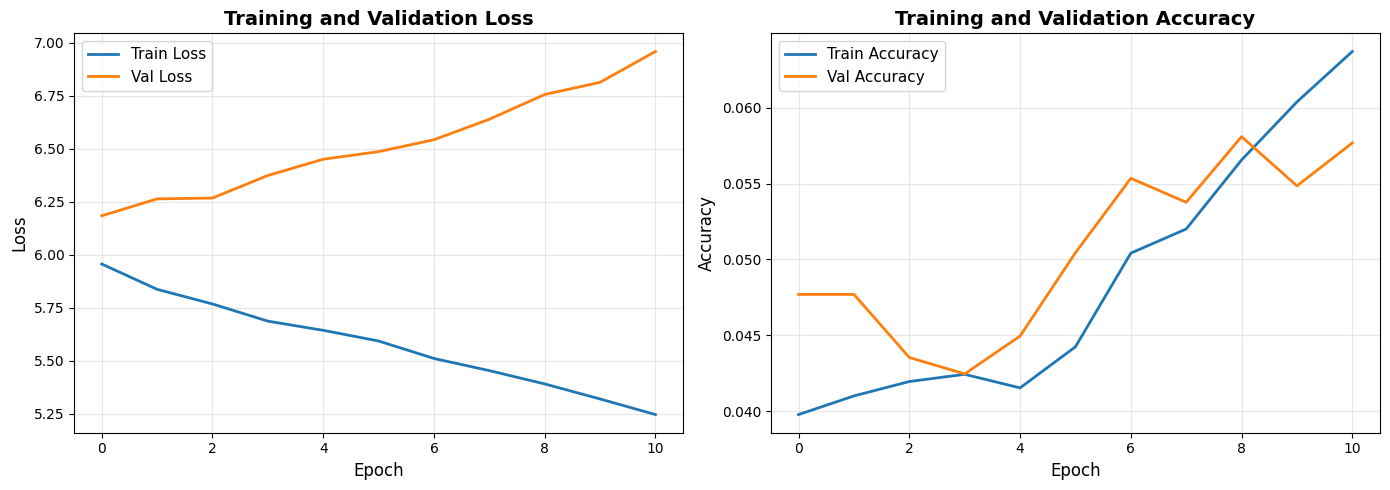

✓ Training history plot saved


In [13]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
axes[0].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Accuracy plot
axes[1].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[1].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, f'training_history_{timestamp}.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Training history plot saved")

### Step 11: Evaluate on Test Set
Comprehensive evaluation of model performance on held-out test data:
- Overall accuracy
- Per-class precision, recall, F1-score
- Confusion matrix
- ROC-AUC scores (for multi-class)

In [14]:
# Predictions on test set
y_test_pred_probs = model.predict(X_test, verbose=0)
y_test_pred = np.argmax(y_test_pred_probs, axis=1)

# Calculate metrics
test_accuracy = accuracy_score(y_test, y_test_pred)

print("="*70)
print("TEST SET EVALUATION")
print("="*70)
print(f"\nOverall Accuracy: {test_accuracy:.4f}\n")

# Get unique classes in test set
test_classes = np.unique(y_test)
test_class_names = [int_to_label[int(i)] for i in test_classes]

# Classification report - only on classes that appear in test set
print("Per-Class Metrics:")
print("-"*70)
report = classification_report(
    y_test, y_test_pred,
    labels=test_classes,
    target_names=test_class_names,
    digits=4
)
print(report)

# Validation accuracy for reference
y_val_pred_probs = model.predict(X_val, verbose=0)
y_val_pred = np.argmax(y_val_pred_probs, axis=1)
val_accuracy = accuracy_score(y_val, y_val_pred)

print(f"\nValidation Accuracy (final epoch): {val_accuracy:.4f}")

TEST SET EVALUATION

Overall Accuracy: 0.0476

Per-Class Metrics:
----------------------------------------------------------------------
              precision    recall  f1-score   support

   (F) I40.0     0.0000    0.0000    0.0000       116
  (FO) Q21.1     0.0476    1.0000    0.0909       571
 (OSD) Q21.1     0.0000    0.0000    0.0000        75
   (V) I40.0     0.0000    0.0000    0.0000       200
       A08.0     0.0000    0.0000    0.0000         5
       A09.0     0.0000    0.0000    0.0000        10
       A17.8     0.0000    0.0000    0.0000        10
       A18.3     0.0000    0.0000    0.0000         8
       A18.8     0.0000    0.0000    0.0000         5
       A41.9     0.0000    0.0000    0.0000       229
       A49.1     0.0000    0.0000    0.0000        10
       A49.3     0.0000    0.0000    0.0000        86
       A49.8     0.0000    0.0000    0.0000        23
       A49.9     0.0000    0.0000    0.0000        10
       A81.1     0.0000    0.0000    0.0000         

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Validation Accuracy (final epoch): 0.0477


### Step 12: Visualize Confusion Matrix
Display confusion matrix to identify which diagnoses are confused:
- Rows: True labels
- Columns: Predicted labels
- Diagonal elements show correct predictions
- Off-diagonal elements show misclassifications

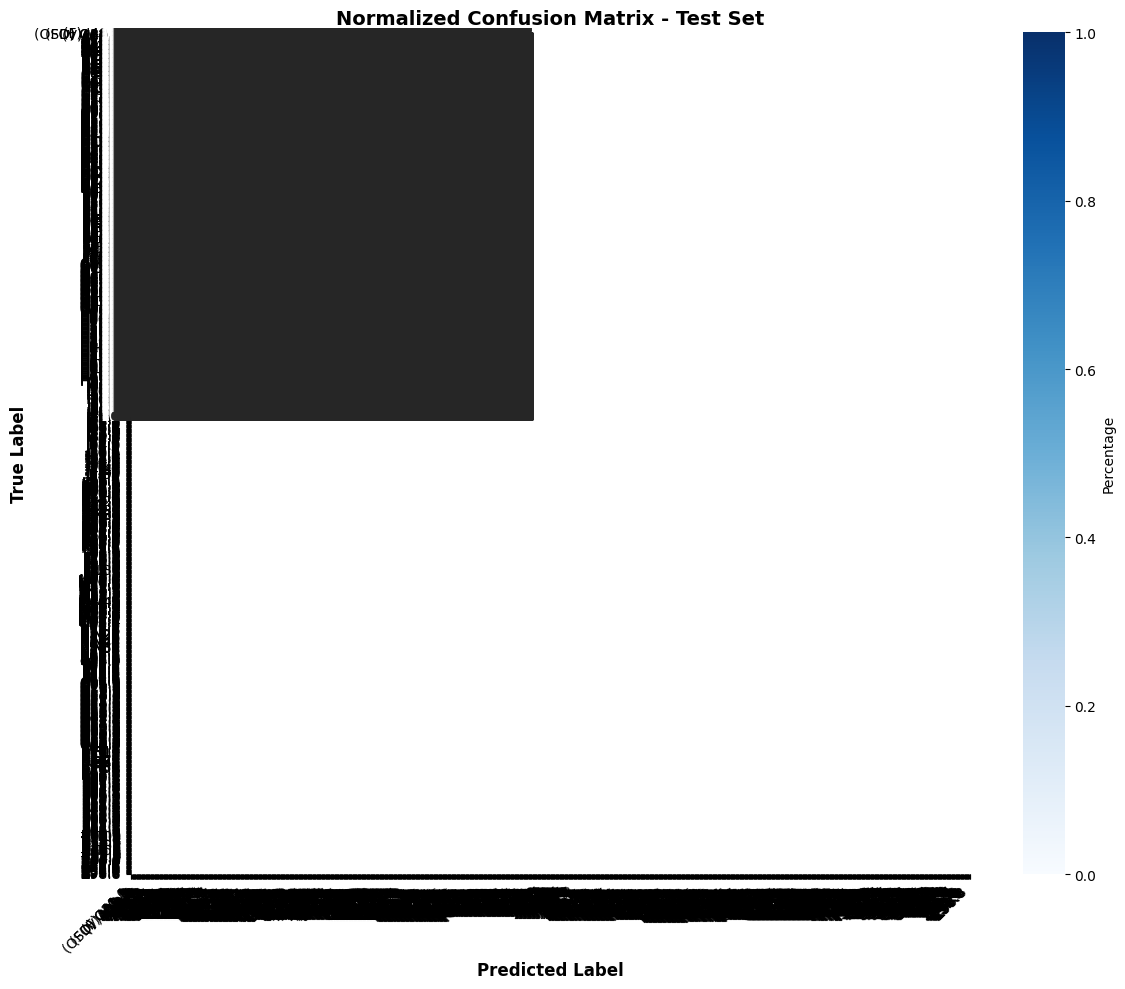

✓ Confusion matrix saved


In [15]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Normalize for visualization
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot
fig, ax = plt.subplots(figsize=(12, 10))

diagnosis_names = [int_to_label[i] for i in range(num_classes)]
sns.heatmap(
    cm_normalized,
    annot=True,
    fmt='.2%',
    cmap='Blues',
    xticklabels=diagnosis_names,
    yticklabels=diagnosis_names,
    cbar_kws={'label': 'Percentage'},
    ax=ax
)

ax.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
ax.set_ylabel('True Label', fontsize=12, fontweight='bold')
ax.set_title('Normalized Confusion Matrix - Test Set', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

plt.savefig(os.path.join(RESULTS_DIR, f'confusion_matrix_{timestamp}.png'), dpi=150, bbox_inches='tight')
plt.show()

print("✓ Confusion matrix saved")

### Step 13: Save Training Results and Summary
Export model, results, and metadata for later analysis:
- Save trained model (HDF5 format)
- Save training metrics (JSON)
- Save test predictions and probabilities (NPZ)
- Create summary report

In [16]:
# Save model in different formats
model_h5_path = os.path.join(RESULTS_DIR, f"baseline_model_{timestamp}.h5")
model_keras_path = os.path.join(RESULTS_DIR, f"baseline_model_{timestamp}.keras")

model.save(model_h5_path)
model.save(model_keras_path)
print(f"✓ Model saved to:")
print(f"  - {model_h5_path}")
print(f"  - {model_keras_path}")

# Save metrics and results
results = {
    'timestamp': timestamp,
    'model_type': 'Baseline 1D CNN',
    'input_shape': list(input_shape),
    'num_classes': num_classes,
    'num_parameters': int(model.count_params()),
    'training_samples': X_train.shape[0],
    'validation_samples': X_val.shape[0],
    'test_samples': X_test.shape[0],
    'epochs_trained': len(history.history['loss']),
    'final_train_loss': float(history.history['loss'][-1]),
    'final_val_loss': float(history.history['val_loss'][-1]),
    'final_train_accuracy': float(history.history['accuracy'][-1]),
    'final_val_accuracy': float(history.history['val_accuracy'][-1]),
    'test_accuracy': float(test_accuracy),
    'label_mapping': label_to_int,
}

results_json_path = os.path.join(RESULTS_DIR, f"training_results_{timestamp}.json")
with open(results_json_path, 'w') as f:
    json.dump(results, f, indent=2)
print(f"✓ Results saved to: {results_json_path}")

# Save predictions
predictions_path = os.path.join(RESULTS_DIR, f"test_predictions_{timestamp}.npz")
np.savez(
    predictions_path,
    y_true=y_test,
    y_pred=y_test_pred,
    y_probs=y_test_pred_probs
)
print(f"✓ Test predictions saved to: {predictions_path}")

# Save training history
history_path = os.path.join(RESULTS_DIR, f"training_history_{timestamp}.json")
history_dict = {
    'loss': [float(x) for x in history.history['loss']],
    'accuracy': [float(x) for x in history.history['accuracy']],
    'val_loss': [float(x) for x in history.history['val_loss']],
    'val_accuracy': [float(x) for x in history.history['val_accuracy']],
}
with open(history_path, 'w') as f:
    json.dump(history_dict, f, indent=2)
print(f"✓ Training history saved to: {history_path}")

✓ Model saved to:
  - /content/drive/MyDrive/DeepLearningECG/artifacts/training_results/baseline_model_20251122_151422.h5
  - /content/drive/MyDrive/DeepLearningECG/artifacts/training_results/baseline_model_20251122_151422.keras
✓ Results saved to: /content/drive/MyDrive/DeepLearningECG/artifacts/training_results/training_results_20251122_151422.json
✓ Test predictions saved to: /content/drive/MyDrive/DeepLearningECG/artifacts/training_results/test_predictions_20251122_151422.npz
✓ Training history saved to: /content/drive/MyDrive/DeepLearningECG/artifacts/training_results/training_history_20251122_151422.json


### Step 14: Create Summary Report
Generate a comprehensive summary report of the training run

In [17]:
summary_report = f"""
╔═══════════════════════════════════════════════════════════════════════╗
║                    BASELINE MODEL TRAINING REPORT                     ║
╚═══════════════════════════════════════════════════════════════════════╝

TRAINING CONFIGURATION
{'-'*73}
Timestamp:              {timestamp}
Model Type:             Baseline 1D CNN
Input Shape:            {input_shape}
Number of Classes:      {num_classes}
Total Parameters:       {results['num_parameters']:,}

DATA SPLITS
{'-'*73}
Train Set:              {X_train.shape[0]:,} windows from {len(train_patients)} patients
Validation Set:         {X_val.shape[0]:,} windows from {len(val_patients)} patients
Test Set:               {X_test.shape[0]:,} windows from {len(test_patients)} patients
Total:                  {X_train.shape[0] + X_val.shape[0] + X_test.shape[0]:,} windows

TRAINING RESULTS
{'-'*73}
Total Epochs Trained:   {results['epochs_trained']}
Final Train Loss:       {results['final_train_loss']:.6f}
Final Train Accuracy:   {results['final_train_accuracy']:.4f}
Final Val Loss:         {results['final_val_loss']:.6f}
Final Val Accuracy:     {results['final_val_accuracy']:.4f}

TEST SET PERFORMANCE
{'-'*73}
Test Accuracy:          {test_accuracy:.4f}

ARTIFACTS SAVED
{'-'*73}
Model (HDF5):           {model_h5_path}
Model (Keras):          {model_keras_path}
Results JSON:           {results_json_path}
Predictions (NPZ):      {predictions_path}
Training History:       {history_path}
Confusion Matrix Plot:  {os.path.join(RESULTS_DIR, f'confusion_matrix_{timestamp}.png')}
Training History Plot:  {os.path.join(RESULTS_DIR, f'training_history_{timestamp}.png')}
Summary Report:         {os.path.join(RESULTS_DIR, f'summary_report_{timestamp}.txt')}

{'-'*73}
Report generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
"""

print(summary_report)

# Save report
report_path = os.path.join(RESULTS_DIR, f"summary_report_{timestamp}.txt")
with open(report_path, 'w') as f:
    f.write(summary_report)

print(f"\n✓ Summary report saved to: {report_path}")


╔═══════════════════════════════════════════════════════════════════════╗
║                    BASELINE MODEL TRAINING REPORT                     ║
╚═══════════════════════════════════════════════════════════════════════╝

TRAINING CONFIGURATION
-------------------------------------------------------------------------
Timestamp:              20251122_151422
Model Type:             Baseline 1D CNN
Input Shape:            (5000, 1)
Number of Classes:      1493
Total Parameters:       682,485

DATA SPLITS
-------------------------------------------------------------------------
Train Set:              35,843 windows from 6985 patients
Validation Set:         12,034 windows from 2329 patients
Test Set:               11,991 windows from 2329 patients
Total:                  59,868 windows

TRAINING RESULTS
-------------------------------------------------------------------------
Total Epochs Trained:   11
Final Train Loss:       5.246779
Final Train Accuracy:   0.0637
Final Val Loss:      